# Practical Machine Learning and Deep Learning

# Lesson 6

# Transfer Learning in Computer Vision

Transfer learning in machine learning is a technique where a model developed for a specific task is reused as the starting point for a model on a second task. It leverages the knowledge gained from a pre-trained model on a large dataset to improve the performance on a different but related task, usually with a smaller dataset. This method can significantly reduce the computational resources and time required to train a model and often leads to better performance when the target dataset is limited in size.

The key steps involved in transfer learning are:

1. **Loading a Pre-trained Model**: A model pre-trained on a large and general dataset (such as ImageNet) is loaded. These models have already learned useful features that can be transferable to other tasks.
   
2. **Modifying the Model**: The final layer or layers of the pre-trained model are typically replaced to fit the specific number of output classes of the new task. This adaptation allows the model to produce predictions that are relevant to the new task.

3. **Fine-tuning**: The modified model is then fine-tuned on the new, typically smaller, target dataset. Fine-tuning can involve training the entire model or just the new layers, allowing the model to adjust its learned features to better suit the new task.

Transfer learning is particularly beneficial in scenarios where acquiring a large labeled dataset is difficult, and it helps to accelerate the training process and improve model performance by building on existing knowledge.

Let's start this lesson by importing the required libraries

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(0)

## Data reading and preprocessing

Prepare a class for FashionMNIST dataset to easily read data and apply transformations when retrieving examples.
Here you can notice that we are keeping `train` as a boolean. And for test datasets, we keep labels as None.

In [2]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class FashionMNISTDataset(Dataset):
    '''Dataset class for FashionMNIST'''

    def __init__(self, csv_path, train=True):
        ''' Read data and prepare tranforms

            Args:
            - csv_path(str): full name of the csv file
            - train(bool): is train set loaded, determines whether to return labels
        '''
        self.csv_path = csv_path
        self.train = train

        self.transform = transforms.Compose([
            # Make tensors
            transforms.ToTensor(),
            # Question: Do we always need to resize the images to the input
            # shape of the pretrained model? Resize them if required
            transforms.Resize((224, 224), antialias=None),
        ])

        # Read csv file of the dataset and set index_col to 0
        self.fm_raw = pd.read_csv(csv_path, index_col=0)

        if train:
            # Extract the pixel values of the images as a numpy array
            self.images = self.fm_raw.values
            # Reshape images to have 28x28 shape
            self.images = self.images.reshape(-1, 28, 28)
            # Make pixels vary from 0 to 1
            self.images = self.images / 255
            # The last column of the dataframe stores that labels. Extract them.
            self.labels = self.fm_raw.iloc[:, -1].values
        else:
            # Extract the pixel values of the images as a numpy array
            self.images = self.fm_raw.values
            # Reshape images to have 28x28 shape
            self.images = self.images.reshape(-1, 28, 28)
            # Make pixels vary from 0 to 1
            self.images = self.images / 255
            # There is no labels in the test dataset, so they are set to None
            self.labels = None

    def __getitem__(self, index):
        '''Returns the data of the example at the given index'''
        if self.train:
            # Get images at the given index
            images = self.images[index]
            # Transform the images
            transformed_images = self.transform(images)
            # Get labels at the given index
            labels = self.labels[index]
            # Return transformed_images and labels as a pair
            return transformed_images, labels
        else:
            # Get images at the given index
            images = self.images[index]
            # Transform the images
            transformed_images = self.transform(images)
            # Return only transformed images since it is a testing subset
            return transformed_images

    def __len__(self):
        '''Returns length of the dataset'''
        return len(self.images)

## Read Data and Split into Train and Test|

Read data and prepare a dataset

In [4]:
import os

filename = "fashion-mnist_train.csv"

dataset = FashionMNISTDataset(csv_path=filename, train=True)

Split the dataset into training and validation subsets using `random_split`

In [5]:
from torch.utils.data import random_split

# Set percentage of data to use as a training subset
train_ratio = 0.8

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, (train_size, test_size))

## Use DataLoggers

Make dataloader to perform batching and apply transformations.

Using a `DataLoader` in PyTorch is essential for efficiently managing data during training and evaluation of machine learning and deep learning models. It integrates seamlessly with other PyTorch utilities and functions. In a longer run, we will formalise our machine learning tasks even more. Let's look at some other benefits we can have with `Dataloader`:

1. **Batching**:
   - `DataLoader` handles the batching of data, which means it can divide the dataset into smaller chunks (batches). This is crucial for training as it allows the model to process multiple samples simultaneously, making the training process faster and more stable.

2. **Shuffling**:
   - It can shuffle the data, which is important to ensure that the model does not learn patterns that are specific to the order of the data. Shuffling helps in making the training process more robust and can lead to better generalization.

3. **Parallelism**:
   - `DataLoader` supports parallel data loading by using multiple worker threads or processes. This allows data loading to be done in parallel with model training, ensuring that the GPU or CPU is not waiting idly for data to be loaded.

4. **Handling of Complex Datasets**:
   - It can handle complex datasets that include not just plain tensors but also images, text, and other data types. Custom `Dataset` classes can be defined, and `DataLoader` will seamlessly work with them to provide the necessary data during training and evaluation.

5. **Automatic Batching and Padding**:
   - For tasks like sequence modeling, where input lengths can vary, `DataLoader` can automatically pad sequences to the same length within a batch. This is especially useful in natural language processing tasks.



In [6]:
from torch.utils.data import DataLoader

# Set the batch size
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Visually check the images

Now we will visually check the images in the dataset. This is step helpful for ensuring data quality and consistency. It also helps identify corrupt or mislabeled images, class imbalances, and formatting inconsistencies, such as differing dimensions or color channels. This step also verifies the relevance and diversity of the images, ensuring they adequately represent the conditions the model will encounter. Additionally, visual checks aid in determining appropriate data augmentation techniques and catching anomalies early, preventing wasted computational resources and improving overall model performance.

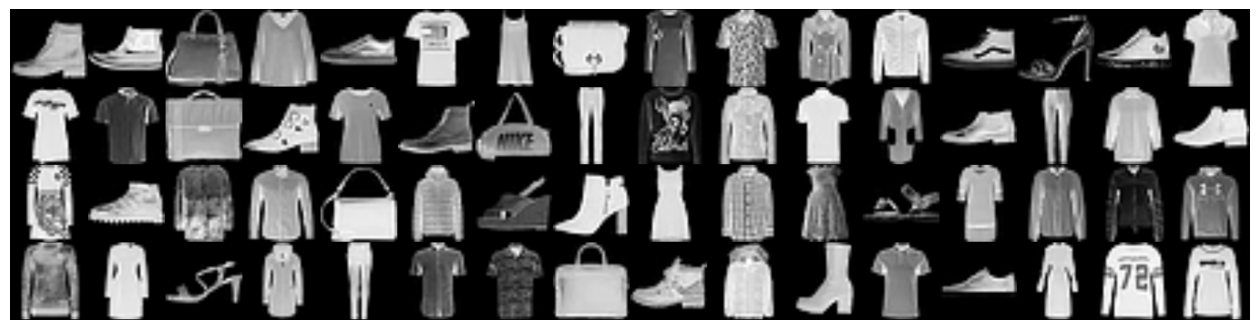

In [7]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model Implementation
Implement a PyTorch model that uses a pretrained model for computer vision to classify the clothes. You are allowed to use any models initially trained for other tasks (e.g. VGG, ResNet, etc). You may experiment with [freezing](https://pytorch.org/docs/master/notes/autograd.html#setting-requires-grad) some layers of the pretrained model. If you are interested, you may try to build your own CNN model for FashionMNIST classification.

In [8]:
import torchvision.models as models
import torch.nn as nn

class FashionMNISTModel(nn.Module):
  '''PyTorch model for FashionMNIST classification'''

  def __init__(self, in_channels=1):
    '''Sets the pretrained model and makes specific modifications'''
    super(FashionMNISTModel, self).__init__()

    # Here you load a pretrained model and
    # add modifications to classify FashionMNIST 28x28 grayscale images
    # out of 10 possible labels

    # Load a pretrained resnet model from torchvision.models in Pytorch
    self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Change the input layer to take Grayscale image, instead of RGB images.
    # Hence in_channels is set as 1 or 3 respectively
    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Change the output layer to output 10 classes instead of 1000 classes
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    '''Determines the sequence of actions to classify images x'''
    return self.model(x)

In [9]:
# Select the where to perform calculations
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Create an instance of the model and pass its weights to the device
model = FashionMNISTModel().to(device)
# Set the loss function
loss_function = nn.CrossEntropyLoss()
# Set the opimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # Using Karpathy's learning rate constant

## Model Training

Fine-tuning of the pretrained model on our specific task of clothes classification.

Here are utility functions to calculate and show metrics:

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metric(metric_fn, true_y, pred_y):
    if metric_fn != accuracy_score:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)

def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

Now we will perform three main steps:
1. **Training Loop**:
   - The training loop will iterate over the training dataset (`train_loader`) for the specified number of epochs. For each batch, it will perform the following:
     - Set the model to training mode with `model.train()`.
     - Clear previous gradients with `model.zero_grad()`.
     - Compute the model outputs with `outputs = model(X)`.
     - Calculate the loss between the outputs and the true labels with `loss = loss_function(outputs, y)`.
     - Backpropagate the loss to compute gradients with `loss.backward()`.
     - Update the model parameters with `optimizer.step()`.
     - Track and update the running total loss, updating the progress bar with the current average loss.

2. **Validation Loop**:
   - After the training loop, the validation loop will evaluate the model's performance on the validation dataset (`val_loader`):
     - Set the model to evaluation mode with `model.eval()` and ensure no gradients are computed with `torch.no_grad()`.
     - For each batch in the validation set, it will compute the model outputs and update the running total validation loss.
     - Calculate predicted classes and compute precision, recall, F1 score, and accuracy for the batch, appending these metrics to their respective lists.

3. **Logging and Memory Management**:
   - After completing training and validation for an epoch, it will print the training and validation losses, as well as the evaluation metrics for precision, recall, F1 score, and accuracy.
   - The `torch.cuda.empty_cache()` call will ensure that unnecessary memory is released in the GPU to manage memory efficiently.
   - The losses for each epoch will be stored in a list for potential further analysis or plotting.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

epochs = 1

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  --------------------
    # set model to training
    model.train()

    for i, data in progress:
        X, y = data[0].to(device).float(), data[1].to(device)

        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        # update running training loss
        current_loss = loss.item()
        total_loss += current_loss * X.size(0)

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # ----------------- VALIDATION  -----------------
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []

    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device).long() , data[1].to(device).long()

            outputs = model(X)

            # update running validation loss
            val_losses += loss_function(outputs, y) * X.size(0)

            predicted_classes = torch.max(outputs, 1)[1]

            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy),
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )

    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches)

## Inference

In this step we will produce labels on the testing images using inference. But before moving to inference, we need to do the following:

1. Get the test part of the dataset
2. Use dataloaders for this dataset

And then we can move on to perform predictions and generating labels

### Load the dataset in the testing mode

In [12]:
test_dataset = FashionMNISTDataset(csv_path=filename, train=False)

### Make a loader of the testing dataset

In [13]:
test_loader = DataLoader(test_dataset, batch_size=64)

### Make predictions and generate a submission file

In [ ]:
predictions = []

with torch.no_grad():
    model.eval()
    for i, images in enumerate(test_loader):
        X = images.to(device).float()
        outputs = model(X)
        predicted = torch.max(outputs, 1)[1]
        predictions.extend(predicted.tolist())

### Save the results

In [ ]:
# generate the submission file
results = pd.DataFrame(columns=['id', 'label'])
results['id'] = test_dataset.fm_raw.index
results['label'] = predictions
results.to_csv('results.csv', index=None)